In [279]:
pip install node2vec


  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 22.0 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.6/59.6 kB 8.6 MB/s eta 0:00:00
  Created wheel for fst-pso: filename=fst_pso-1.8.1-py3-none-any.whl size=20430 sha256=1f1cee4971c811d154882d0837138348ddcd8eed73aa159f864bed6c2d28b7e4
  Stored in directory: /Users/jojolapatate/Library/Caches/pip/wheels/69/f5/e5/18ad53fe1ed6b2af9fad05ec052e4acbac8e92441df44bad2e
  Created wheel for miniful: filename=miniful-0.0.6-py3-none-any.whl size=3513 sha256=15fd9f5c2cfdad0eded8651dcb01101f189d80655e28baa81f48fa7023e8ccdc
  Stored in directory: /Users/jojolapatate/Library/Caches/pip/wheels/9d/ff/2f/afe4cd56f47de147407705626517d68bea0f3b74eb1fb168e6
Successfully built fst-pso miniful
  Attempting uninstall: networkx
    Found existing installation: networkx 3.1
    Uninstalling networkx-3.1:
      Successfully uninstalled networkx-3.1

[no

In [323]:
pip install torch-geometric


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.2/64.2 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 29.6 MB/s eta 0:00:00

[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [328]:
#modeling jo
import numpy as np
import csv
import pandas as pd
pd.set_option('display.max_columns', None)
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
import networkx.algorithms.community as community
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from scipy.stats import randint as sp_randint
from node2vec import Node2Vec
from sklearn.model_selection import RandomizedSearchCV, learning_curve, cross_validate, cross_val_predict, StratifiedKFold, GridSearchCV, train_test_split

In [329]:
from sklearn.preprocessing import StandardScaler

# 2. Charger les données
test_set_final = pd.read_csv("../data/test_set_final.csv", sep=",")
train_set_final = pd.read_csv("../data/train_set_final.csv", sep=",")
node_info = pd.read_csv("../data/node_information.csv", header=None)
test_set = pd.read_csv("../data/test.txt", sep=" ", header=None, names=['source', 'target'])
train_set = pd.read_csv("../data/train.txt", sep=" ", header=None, names=['source', 'target', 'label'])


In [314]:

def salton_similarity(G, edges):
    for u, v in edges:
        common_neighbors = len(list(nx.common_neighbors(G, u, v)))
        degree_u = G.degree(u)
        degree_v = G.degree(v)
        yield u, v, common_neighbors / ((degree_u * degree_v) ** 0.5)

def preferential_attachement(G, edges):
    PA = {}
    
    for u, v in edges:
        common_neighbors = len(list(nx.common_neighbors(G, u, v)))
        degree_u = G.degree(u)
        degree_v = G.degree(v)
        yield u, v, degree_u * degree_v
    

def sorenson_similarity(G, edges):
    for u, v in edges:
        common_neighbors = len(list(nx.common_neighbors(G, u, v)))
        degree_u = G.degree(u)
        degree_v = G.degree(v)
        yield u, v, 2 * common_neighbors / (degree_u + degree_v)


def hub_promoted_similarity(G, edges):
    for u, v in edges:
        common_neighbors = len(list(nx.common_neighbors(G, u, v)))
        degree_u = G.degree(u)
        degree_v = G.degree(v)
        yield u, v, common_neighbors / min(degree_u, degree_v)

def hub_depressed_similarity(G, edges):
    for u, v in edges:
        common_neighbors = len(list(nx.common_neighbors(G, u, v)))
        degree_u = G.degree(u)
        degree_v = G.degree(v)
        yield u, v, common_neighbors / max(degree_u, degree_v)

def adamic_adar_index(G, edges):
    for u, v in edges:
        score = 0
        for w in nx.common_neighbors(G, u, v):
            degree_w = G.degree(w)
            if degree_w > 1:
                score += 1 / np.log(degree_w)
        yield u, v, score

# Creer une fonction qui ajoute des features (degree, centrality, clustering) à un graphes et qui merge node_info avec le graphe
def add_node_attributes(df, node_info):
     # Créer un graphe à partir du df
     if 'label' in df.columns:
        G = nx.from_pandas_edgelist(df, 'source', 'target', 'label')
     else:
        G = nx.from_pandas_edgelist(df, 'source', 'target')

     # Calculer les caractéristiques
     df['degree_source'] = df['source'].apply(lambda x: G.degree(x))
     df['centrality_source'] = df['source'].apply(lambda x: nx.degree_centrality(G)[x])
     #df['clustering_source'] = df['source'].apply(lambda x: nx.clustering(G)[x])

     df['degree_target'] = df['target'].apply(lambda x: G.degree(x))
     df['centrality_target'] = df['target'].apply(lambda x: nx.degree_centrality(G)[x])
     #df['clustering_target'] = df['target'].apply(lambda x: nx.clustering(G)[x])

     # Détecter les communautés et créer une caractéristique de communauté
     communities = nx_community.greedy_modularity_communities(G)
     community_map = {}
     for i, community in enumerate(communities):
          for node in community:
               community_map[node] = i
     df['community_source'] = df['source'].apply(lambda x: community_map[x])
     df['community_target'] = df['target'].apply(lambda x: community_map[x])

     df['pa'] = [i[2] for i in preferential_attachement(G, df[['source', 'target']].values.tolist())]

     # Calculer le coefficient de Jaccard
     df['jaccard'] = [i[2] for i in nx.jaccard_coefficient(G, df[['source', 'target']].values)]

     # Calculer le coefficient de similarité de Salton
     df['salton'] = [i[2] for i in salton_similarity(G, df[['source', 'target']].values.tolist())]

     # Calculer le coefficient de similarité de Sorenson
     df['sorenson'] = [i[2] for i in sorenson_similarity(G, df[['source', 'target']].values.tolist())]

     # Calculer le coefficient de similarité de Hub Promoted
     df['hub_promoted'] = [i[2] for i in hub_promoted_similarity(G, df[['source', 'target']].values.tolist())]

     # Calculer le coefficient de similarité de Hub Depressed
     df['hub_depressed'] = [i[2] for i in hub_depressed_similarity(G, df[['source', 'target']].values.tolist())]

     # Calculer le coefficient de similarité de Leicht-Holme-Newman
     df['leicht_holme_newman'] = [i[2] for i in nx.preferential_attachment(G, df[['source', 'target']].values)]

     # Calculer le coefficient de similarité de adamic_adar
     df['adamic_adar'] = [i[2] for i in adamic_adar_index(G, df[['source', 'target']].values.tolist())]

     # Calculer le coefficient de similarité de resource_allocation_index
     df['resource_allocation'] = [i[2] for i in nx.resource_allocation_index(G, df[['source', 'target']].values)]

     # Calculer les common neighbors
     df['common_neighbors'] = df.apply(lambda x: len(list(nx.common_neighbors(G, x['source'], x['target']))), axis=1)
    
     shortest_paths = dict(nx.all_pairs_shortest_path_length(G))
     df['shortest_path_length'] = [shortest_paths.get((source, target), -1) for source, target in zip(df['source'], df['target'])]

    # Calculate eigenvector centrality
     eigenvector_centrality = nx.eigenvector_centrality_numpy(G)
     df['eigenvector_centrality_source'] = df['source'].apply(lambda x: eigenvector_centrality.get(x, 0))
     df['eigenvector_centrality_target'] = df['target'].apply(lambda x: eigenvector_centrality.get(x, 0))

     node2vec = Node2Vec(G, dimensions=64, walk_length=30, num_walks=200, workers=4)
     model = node2vec.fit(window=10, min_count=1, batch_words=4)

     node_embeddings = {}
     for node in G.nodes():
        if node in model.wv:
            node_embeddings[node] = model.wv[node]
        else:
            node_embeddings[node] = np.zeros(64)  # Default embedding for missing nodes

     df['embedding_source'] = df['source'].apply(lambda x: node_embeddings.get(x, np.zeros(64)))
     df['embedding_target'] = df['target'].apply(lambda x: node_embeddings.get(x, np.zeros(64)))
     
     # Fusionner node_info avec le df
     node_info.rename(columns={0: 'node_id'}, inplace=True)
     df = df.merge(node_info, left_on='source', right_on='node_id', how='left')
     # rename toutes les colonnes de node_info ajouter par "nom_col"+"source"
     df.rename(columns={col: str(col) + '_source' for col in node_info.columns[1:]}, inplace=True)
     df.drop('node_id', axis=1, inplace=True)


     df = df.merge(node_info, left_on='target', right_on='node_id', how='left')
     # rename toutes les colonnes de node_info ajouter par "nom_col"+"source"
     df.rename(columns={col: str(col) + '_target' for col in node_info.columns[1:]}, inplace=True)
     df.drop('node_id', axis=1, inplace=True)
     return df

# Ajouter les caractéristiques au train_set
train_set = add_node_attributes(train_set, node_info)
test_set = add_node_attributes(test_set, node_info)

train_set.head()


Computing transition probabilities:   0%|          | 0/3597 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 50/50 [00:12<00:00,  4.11it/s]


Computing transition probabilities:   0%|          | 0/2856 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 50/50 [00:08<00:00,  6.06it/s]


source  target  label  degree_source  centrality_source  degree_target  \
0     939    3809      1              4           0.001112            361   
1    2442    5784      1             11           0.003059              4   
2     179    3809      1              8           0.002225            361   
3     857    2280      1              9           0.002503             21   
4    1358    5722      1              3           0.000834             17   

   centrality_target  community_source  community_target    pa   jaccard  \
0           0.100389                 2                 0  1444  0.000000   
1           0.001112                 3                 3    44  0.071429   
2           0.100389                 0                 0  2888  0.005450   
3           0.005840                 0                 4   189  0.000000   
4           0.004727                 2                 2    51  0.000000   

     salton  sorenson  hub_promoted  hub_depressed  leicht_holme_newman  \
0  0.000000  0.000000          0.00       0.000000                 1444   
1  0.150756  0.133333          0.25       0.090909                   44   
2  0.037216  0.010840          0.25       0.005540                 2888   
3  0.000000  0.000000          0.00       0.000000                  189   
4  0.000000  0.000000          0.00       0.000000                   51   

   adamic_adar  resource_allocation  common_neighbors  shortest_path_length  \
0     0.000000             0.000000                 0                    -1   
1     0.513898             0.142857                 1                    -1   
2     0.857549             0.194444                 2                    -1   
3     0.000000             0.000000                 0                    -1   
4     0.000000             0.000000                 0                    -1   

   eigenvector_centrality_source  eigenvector_centrality_target  \
0                       0.036479                       0.693586   
1                       0.002788                       0.000319   
2                       0.040864                       0.693586   
3                       0.037566                       0.005744   
4                       0.000397                       0.001462   

                                    embedding_source  \
0  [0.7162851, -0.050993066, 0.16044705, 0.076216...   
1  [-0.0052416488, -0.28008896, 0.33490556, 0.524...   
2  [-0.057708014, -0.3840912, 0.7267375, -0.02834...   
3  [0.06535124, -0.22377092, -0.5240191, 0.340784...   
4  [0.29774892, -0.516894, -0.15750852, 0.4899435...   

                                    embedding_target  1_source  2_source  \
0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...       0.0       0.0   
1  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...       0.0       0.0   
2  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...       0.0       0.0   
3  [-0.30989692, -0.5647565, 0.021885669, 0.57298...       0.0       0.0   
4  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...       0.0       0.0   

   3_source  4_source  5_source  6_source  7_source  8_source  9_source  \
0       0.0       0.0       0.0       0.0       0.0       0.0       0.0   
1       0.0       0.0       0.0       0.0       0.0       0.0       0.0   
2       0.0       0.0       0.0       0.0       0.0       0.0       0.0   
3       0.0       0.0       0.0       0.0       0.0       0.0       0.0   
4       0.0       0.0       0.0       0.0       0.0       0.0       0.0   

   10_source  11_source  12_source  13_source  14_source  15_source  \
0        0.0        0.0        0.0        0.0        0.0        0.0   
1        0.0        0.0        0.0        0.0        0.0        0.0   
2        0.0        0.0        0.0        0.0        0.0        0.0   
3        0.0        0.0        0.0        0.0        0.0        0.0   
4        0.0        0.0        0.0        0.0        0.0        0.0   

   16_source  17_source  18_source  19_source  20_source  21_source  \
0        0.

In [348]:
train_set

,source,target,label
0,939,3809,1
1,2442,5784,1
2,179,3809,1
3,857,2280,1
4,1358,5722,1
...,...,...,...
10491,81,6464,0
10492,4,6433,0
10493,3341,6717,1
10494,1562,4656,0


In [343]:
from torch_geometric.data import Data

# Define node features, edge index, and edge labels
num_nodes = max(train_set_final['source'].max(), train_set_final['target'].max()) + 1
num_features = 900  # Adjust this based on the actual number of features per node
node_features = torch.randn(num_nodes, num_features)  # Initialize with random features
edge_index = torch.tensor([train_set_final['source'], train_set_final['target']], dtype=torch.long)
edge_labels = torch.tensor(train_set_final['label'], dtype=torch.long)  # Adjust dtype as needed

# Additional edge attributes
# Extract other edge attributes and convert them into tensors

# Create a Data object
data = Data(x=node_features, edge_index=edge_index, y=edge_labels)
from torch_geometric.utils import train_test_split_edges
data = train_test_split_edges(data)

/Users/jojolapatate/anaconda3/lib/python3.11/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'train_test_split_edges' is deprecated, use 'transforms.RandomLinkSplit' instead
  warnings.warn(out)


/var/folders/bv/5s8wgnqx04n66t4k9rrp0ygh0000gn/T/ipykernel_3857/1651932574.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  source_data.drop(columns = ['source', 'centrality_source','degree_source', 'degree_source', 'community_source', 'resource_allocation', 'embedding_source', 'eigenvector_centrality_source'], inplace = True)


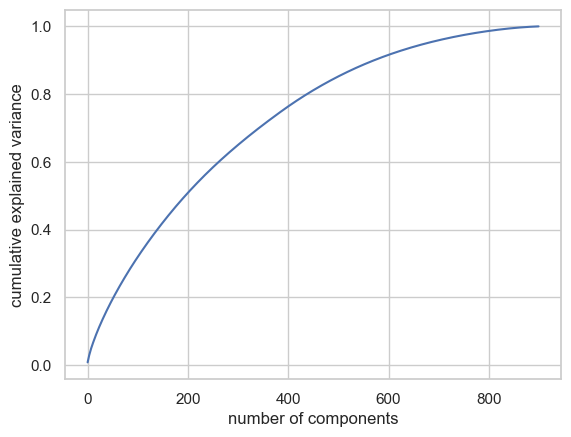

None

In [315]:
source_columns = train_set.columns[train_set.columns.str.contains('source')]

source_data = train_set[source_columns]
source_data.drop(columns = ['source', 'centrality_source','degree_source', 'degree_source', 'community_source', 'resource_allocation', 'embedding_source', 'eigenvector_centrality_source'], inplace = True)

# Standardize the data
scaler = StandardScaler()
source_data_scaled = scaler.fit_transform(source_data)

pca_test = PCA(n_components=900)
pca_test.fit(source_data_scaled)
sns.set(style='whitegrid')
plt.plot(np.cumsum(pca_test.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
#plt.axvline(linewidth=4, color='r', linestyle = '--', x=10, ymin=0, ymax=1)
display(plt.show())
evr = pca_test.explained_variance_ratio_
cvr = np.cumsum(pca_test.explained_variance_ratio_)


/var/folders/bv/5s8wgnqx04n66t4k9rrp0ygh0000gn/T/ipykernel_3857/2593204901.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  target_data.drop(columns = ['target','degree_target','centrality_target','community_target', 'eigenvector_centrality_target', 'embedding_target'], inplace = True)


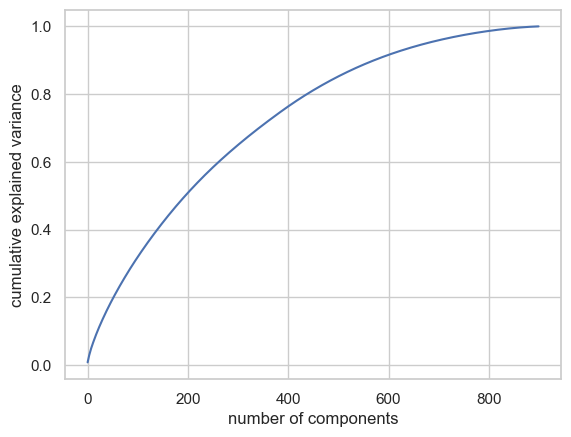

None

In [316]:
target_columns = train_set.columns[train_set.columns.str.contains('target')]

target_data = train_set[target_columns]

target_data.drop(columns = ['target','degree_target','centrality_target','community_target', 'eigenvector_centrality_target', 'embedding_target'], inplace = True)

# Standardize the data
scaler = StandardScaler()
target_data_scaled = scaler.fit_transform(target_data)

pca_test = PCA(n_components=900)
pca_test.fit(source_data_scaled)
sns.set(style='whitegrid')
plt.plot(np.cumsum(pca_test.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
#plt.axvline(linewidth=4, color='r', linestyle = '--', x=10, ymin=0, ymax=1)
display(plt.show())
evr = pca_test.explained_variance_ratio_
cvr = np.cumsum(pca_test.explained_variance_ratio_)

In [317]:
pca = PCA(n_components=420)
source_pca = pca.fit_transform(source_data)
target_pca = pca.fit_transform(target_data)
other_data = train_set.drop(target_data.columns, axis=1)
other_data = other_data.drop(source_data.columns, axis=1)
source_pca_df = pd.DataFrame(source_pca, columns=[f'source_PCA_{i+1}' for i in range(source_pca.shape[1])])
target_pca_df = pd.DataFrame(target_pca, columns=[f'target_PCA_{i+1}' for i in range(target_pca.shape[1])])

train_set_pca = pd.concat([other_data.reset_index(drop=True), source_pca_df, target_pca_df], axis=1)


In [318]:
x_train_val, x_val, y_train_val, y_val = train_test_split(train_set_pca.drop('label', axis=1), train_set_pca['label'], test_size=0.2, random_state=42)


In [319]:
x_train_val.drop(columns=['embedding_source', 'embedding_target'], inplace = True )
x_val.drop(columns=['embedding_source', 'embedding_target'], inplace = True )



In [320]:
rf = RandomForestClassifier(random_state= 42, criterion = "gini",max_depth= 22, n_estimators= 500)
rf.fit(x_train_val, y_train_val)
y_pred = rf.predict(x_val)
y_pred_train = rf.predict(x_train_val)

print(f"Training Accuracy Random Forest: {accuracy_score(y_train_val, y_pred_train)}")
print(f"Validation Accuracy Random Forest: {accuracy_score(y_val, y_pred)}")




#Training Accuracy Random Forest: 0.9681991424487851
#Validation Accuracy Random Forest: 0.731904761904762

Training Accuracy Random Forest: 0.9980943306336351
Validation Accuracy Random Forest: 0.7309523809523809


In [273]:
param_grid = {'n_estimators':np.arange(100,500,50),
              'max_features':np.arange(0.1, 1, 0.1),
              'max_depth': [5, 7, 9, 12, 16],
              'max_samples': [0.3, 0.5, 0.8]}

X = train_set_pca.drop('label', axis=1)
y = train_set_pca['label']

rf = RandomForestClassifier(random_state= 42, criterion = "log_loss")

search = RandomizedSearchCV(rf, param_grid, scoring = 'accuracy', n_iter= 30,cv = 4, refit = True)
result = search.fit(X, y)

best_params = result.best_params_
best_score = result.best_score_

print("Best Parameters:", best_params)
print("Best Accuracy Score:", best_score)


KeyboardInterrupt: 

In [188]:
dtrain = xgb.DMatrix(x_train, label=y_train)
dval = xgb.DMatrix(x_val, label=y_val)

param_dist = {
    'max_depth': sp_randint(7, 10),  # Maximum depth of each tree
    'learning_rate': [0.001, 0.01, 0.1, 0.3],  # Learning rate
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],  # Subsample ratio of the training instances
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0]  # Subsample ratio of columns when constructing each tree
}

xgb_clf = xgb.XGBClassifier(objective='binary:logistic', eval_metric='error')

random_search = RandomizedSearchCV(xgb_clf, param_distributions=param_dist, n_iter=50, scoring='accuracy', cv=3, verbose=1, random_state=42)
random_search.fit(x_train, y_train)

# Get the best parameters
best_params = random_search.best_params_
print("Best Parameters:", best_params)

y_pred = random_search.best_estimator_.predict(x_val)

# Calculate accuracy
accuracy = accuracy_score(y_val, y_pred)
print("Validation Accuracy (XGBoost - Randomized Grid Search):", accuracy)



Fitting 3 folds for each of 50 candidates, totalling 150 fits
Best Parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 7, 'subsample': 0.9}
Validation Accuracy (XGBoost - Randomized Grid Search): 0.7238095238095238


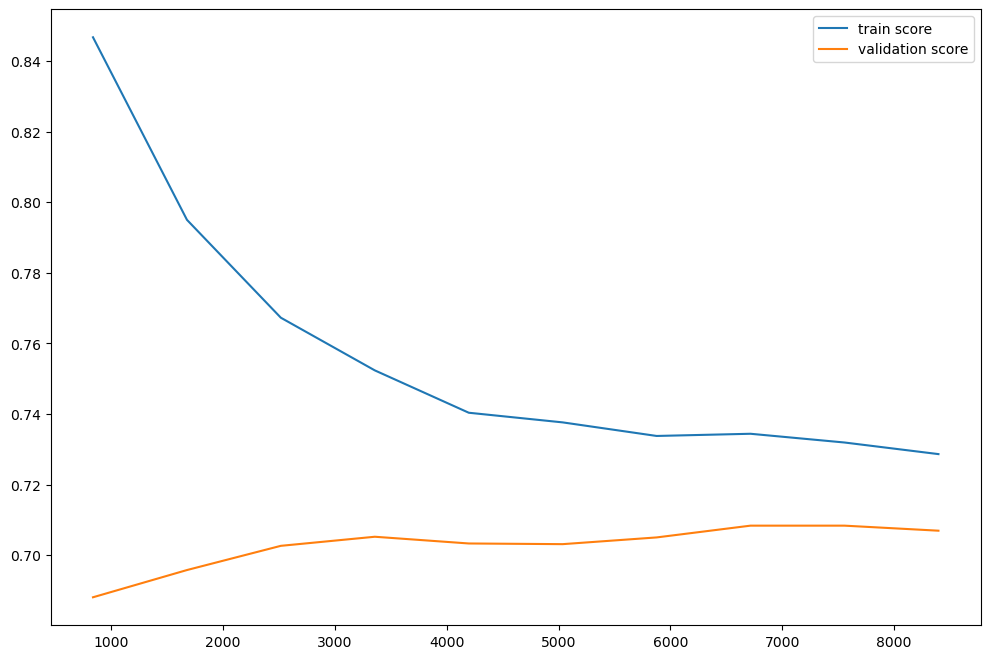

In [30]:
kfold = StratifiedKFold(n_splits=5, random_state=42, shuffle = True)

def evaluation(model):

    N, train_score, val_score = learning_curve(model, x_train, y_train,
                                              cv=kfold, scoring='accuracy',
                                               train_sizes=np.linspace(0.1, 1, 10))


    plt.figure(figsize=(12, 8))
    plt.plot(N, train_score.mean(axis=1), label='train score')
    plt.plot(N, val_score.mean(axis=1), label='validation score')
    plt.legend()

evaluation(model)

SUBMISSIONS

In [ ]:
X_test = test_set_final.drop(columns=['source', 'target'])

# Predict labels for the test set
test_predictions = model.predict(X_test)

# Create a DataFrame with index and predicted labels
predictions_df = pd.DataFrame({'ID': test_set_final.index, 'Predicted': test_predictions})

predictions_df.to_csv('test_predictions.csv', index=False)